# Twitter Sentiment Analysis

## Project Description
Natural language processing (NLP) has many applications, one of the most common being sentiment analysis. Sentiment analysis uses NLP techniques to identify and extract affective states and subjective information. Sentiment analysis itself has a wide range of applications, including in gathering consumer opinions, monitoring mental health, and advertising. The project is to conduct a supervised learning project using labeled sentiment data. The first dataset for this project is provided from the data found in the Kaggle competition: https://www.kaggle.com/datasets/kazanova/sentiment140. This dataset includes 1,600,000 labeled tweets, with: 0 = negative, and 4 = positive. 

## Motivation
For this project, I was deciding between either 1) a CNN-based classification task on medical images, or 2) sentiment analysis on Twitter data. The first project idea was explored but unfortunately unfeasible because of restrictions on sharing the private datasets I have available to me as well as the size of 3D image-based datasets (could not be hosted given Google Colab disk space limitations). As such, I chose the second project to pursue. The motivation behind taking on this project is to learn NLP and its applications. I hoped to begin by learning how to build NLP models for general purposes, then apply it to a specific use case in the future. 

## Learnings
I learned about all the preprocessing steps needed for NLP that aren't present in other forms of ML, including text processing, tokenization, embeddings, and how there are specific architectures designed for NLP (LSTM, BERT). I also learned a lot more about hyperparameter tuning, and found that there are a lot of different aspects that can influence the performance of a model.

## Imports and Data from Kaggle

In [1]:
import pandas as pd
import numpy as np

In [42]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Natural language toolkit
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer # Stemming

stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re # Regular expressions to match words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from tensorflow import keras

In [4]:
print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.8.0


In [7]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!pip install kaggle

In [9]:
# Import Kaggle API key - you have to go to Kaggle and use your own key. 
# You can do this by registering for an account, then finding the API section in your account and 
# downloading the kaggle.json file to upload below.
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [10]:
# Make sure to accept the rules on the Kaggle competition where this data is being used
# otherwise this download will not work!
!kaggle datasets download -d kazanova/sentiment140

 80% 65.0M/80.9M [00:02<00:00, 21.6MB/s]
100% 80.9M/80.9M [00:03<00:00, 28.1MB/s]


In [11]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


## Load in Data

In [12]:
# Data loader 
class FeatureDataset():
  def __init__(self, file_dir, sample_size):
    self.data = pd.read_csv(file_dir, encoding = 'latin-1')
    # Dataset is really large, randomly sample for faster training
    self.data.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text'] # Add dataset column labels
    # Remap the sentiment
    label_to_sentiment = {0: "Negative", 2: "Neutral", 4: "Positive"} 
    self.data.sentiment = self.data.sentiment.map(label_to_sentiment)
    
    self.data = self.data.sample(sample_size, axis = 0)
    self.X_train = self.data.iloc[:int(sample_size*0.75), 5].values
    self.y_train = self.data.iloc[:int(sample_size*0.75), 0].values
    self.X_test = self.data.iloc[int(sample_size*0.75):, 5].values
    self.y_test = self.data.iloc[int(sample_size*0.75):, 0].values

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, index):
    return self.X_train[index], self.y_train[index]

  def make_train_df(self):
    train = pd.DataFrame(self.X_train, self.y_train).reset_index()
    train.columns = ['sentiment', 'text']
    return train

  def make_test_df(self):
    test = pd.DataFrame(self.X_test, self.y_test).reset_index()
    test.columns = ['sentiment', 'text']
    return test

In [107]:
# Explore the data and characteristics
dataset = FeatureDataset("/content/training.1600000.processed.noemoticon.csv", 10000)

In [108]:
dataset.data.head()

,sentiment,id,date,query,user_id,text
1225409,Positive,1990683826,Mon Jun 01 05:29:55 PDT 2009,NO_QUERY,Liyah_Love12,In Class Boredddddd
610188,Negative,2224038141,Thu Jun 18 09:00:51 PDT 2009,NO_QUERY,Annmarie101,is wonderin why on earth facebook wont let me ...
1142173,Positive,1977271606,Sat May 30 20:33:07 PDT 2009,NO_QUERY,sponsler,Ummm...I may or may not be tweeting from a str...
376452,Negative,2051677330,Fri Jun 05 22:32:31 PDT 2009,NO_QUERY,Beeepers,"Right when I was about to go have fun, joy mak..."
1054503,Positive,1962009112,Fri May 29 10:22:55 PDT 2009,NO_QUERY,zoja87,"Back home , bought some spaghetti ingridients ..."


Text(0.5, 1.0, 'Training Data Sentiment Label Distribution')

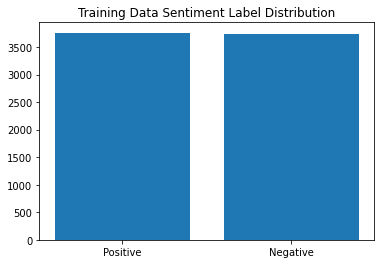

In [109]:
train_counts = dataset.make_train_df().sentiment.value_counts()
plt.bar(train_counts.index, train_counts.values)
plt.title("Training Data Sentiment Label Distribution")

Text(0.5, 1.0, 'Test Set Sentiment Label Distribution')

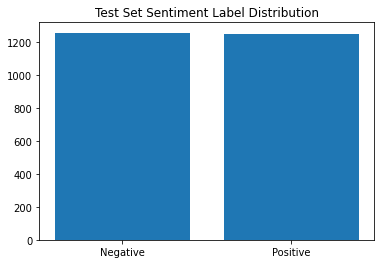

In [110]:
test_counts = dataset.make_test_df().sentiment.value_counts()
plt.bar(test_counts.index, test_counts.values)
plt.title("Test Set Sentiment Label Distribution")

The distribution of data between positive and negative classifications seem fairly balanced in the training and testing datasets with no skewness.

Making a wordcloud because I'm curious to know which words are associated with 'positive' and 'negative' emotions.



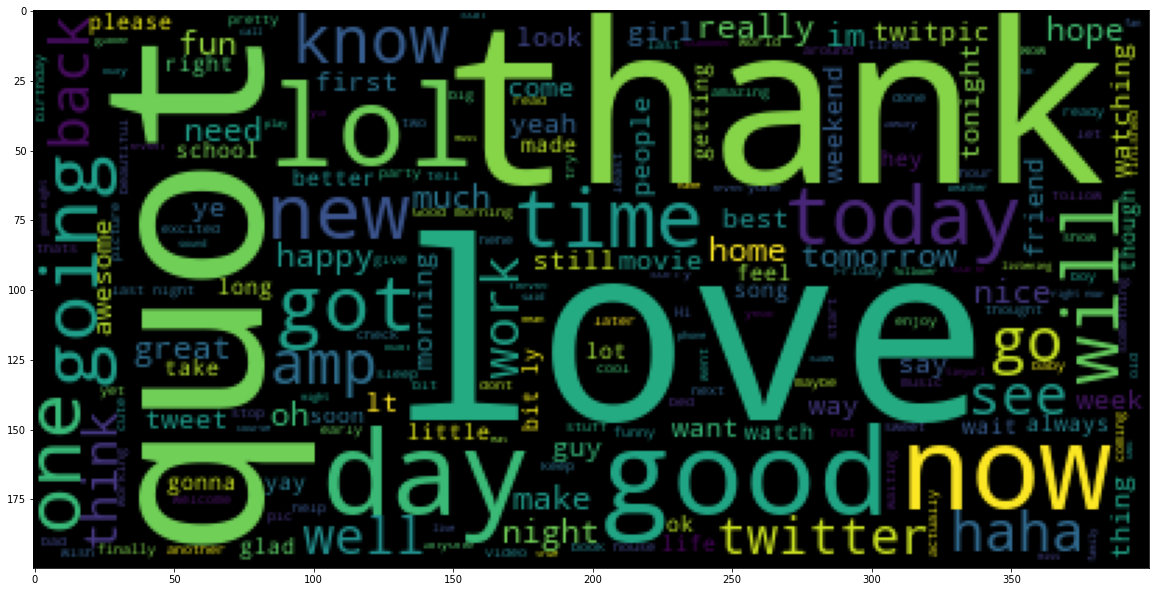

In [111]:
from wordcloud import WordCloud

pos_text = dataset.data[dataset.data.sentiment == 'Positive'].text
neg_text = dataset.data[dataset.data.sentiment == 'Negative'].text
pos_wc = WordCloud().generate(" ".join(pos_text))
neg_wc = WordCloud().generate(" ".join(neg_text))
plt.figure(figsize=(20,20))
plt.imshow(pos_wc)

Interesting results - words like 'good' and 'love', as well as 'nice', 'thank' and 'friend'. However,  that I also notice there is likely a lot of noise from words like 'quot' and 'amp' which are likely symbols, as well as words like 'im', 'go', and 'twitter' which are likely words that just happen to be commonplace on Twitter.

In [112]:
# Checking why "quot" and "amp" seem to be included in the word cloud
for i in pos_text[1:100]:
  if 'amp' and 'quot' in i:
    print(i)

If only we could do this Eurovision style. &quot;This is Michael from East of England, the electorate have voted and....&quot; 
Time to go to sleep after a long night of doing comedy and celebrating Dan &quot;the fuck master&quot; Madonia's birthday 
@unitechy speakin of marathi movies.. I've watched one.. &quot;shwaas&quot; and absolutely loved it.. hope u hve watched tht mulgi 
urgh, Food Tech coursework should be illegal, no joke.  i'm sooo happy, for no reason  *HIGH FIVE* @WollysHolly &quot;OO OO OO!!&quot; ;)
@warlockuk - I quite like - my chemical romance   Tho I'm having a &quot;within temptation&quot; day today 
says : &quot;in order to succeed, we must have the courage both fail and to try again.&quot;  


As you can see, quot and amp are likely just derivations from symbols. We need to remove these commonwords and these symbols in case it confounds learning.

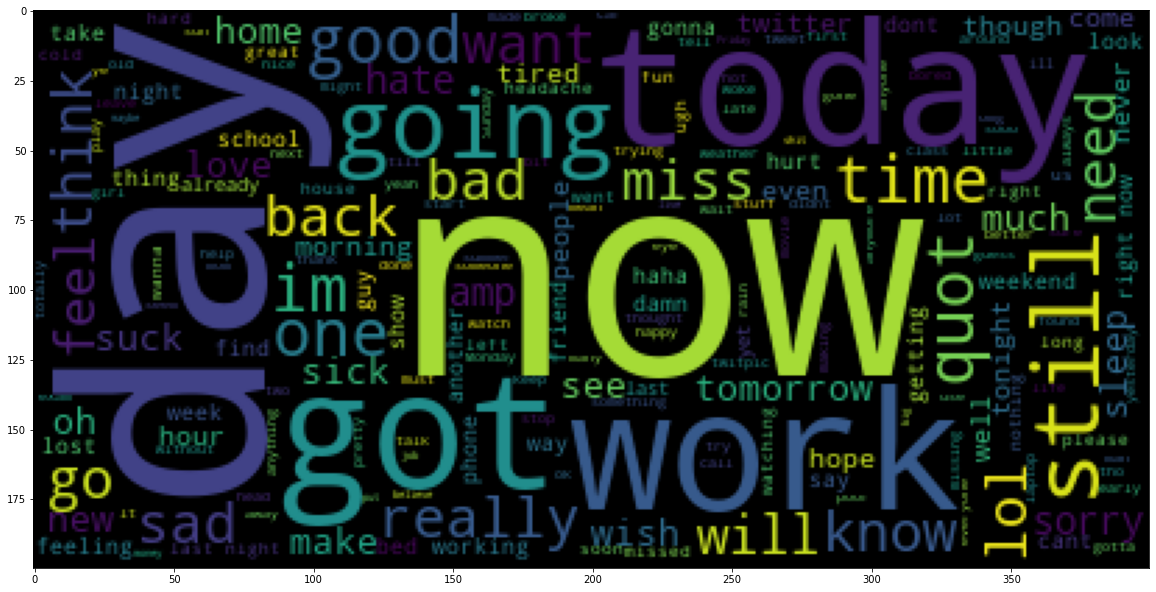

In [113]:
plt.figure(figsize=(20,20))
plt.imshow(neg_wc)

Similarly with negative comments, you can see expected words. I find it very interesting that 'work', 'now' and 'still' are included - maybe the idea of 'now' induces a time-based stress in users that leads to negativitiy, and similarly ideas involved with 'still' can lead to frustration. And of course, I can empathize with Twitter users about why 'work' is associated with negative emotion 🤕. I also find it interesting that words like 'hate' and 'sad' aren't as prevalent as 'work', 'now', or 'still'. Perhaps this is because these words tend not to be as expressed on social media - people might keep that more to themselves. There are also a lot of stopwords - which again shows a need for text preprocessing.

## Text Preprocessing
Text in tweets tend to have a lot of extraneous hyperlinks, punctuation, emojis, etc. It is important in NLP applications to preprocess text before training. There are three important steps:
- **Remove stopwords**: stopwords are commonly used words in the English language. These words have no contextual meaning in an sentence, so therefore we remove them before classification. Some stopwords are.. 'i', 'me', 'my', 'myself', etc.

- **'Stemming' words**: There are many grammatical versions of words, for example write, writing and writes. There are also families of derived or related words with similar meanings. The goal of stemming is to reduce alternate, inflectional, and related forms of a word to a common base form. Stemming does this through a process that chops off the ends of words. For example, 'adjust*able*' -> 'adjust'.

- **Lemmatization**: Much like stemming, the goal of lemmatization is also to reduce extraneous forms of words. Lemmatization, however, refers to using a morphological analysis of words. It removes inflectional endings only (ie., 'go*ing*' -> 'go') and also turns synonyms into a base or dictionary form of a word. (ie., 'better' -> 'good')

A final form of text processing that needs to be done is removal of hyperlinks, which are prolific in Tweets. This can be done through applying regular expressions (**regex**) which is a system that uses a specific series of commands to match and identify patterns in other strings. (ex., I can regex the https: of a link)


In [115]:
# Regex to clean hyperlinks
# https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
def remove_URL(text):
    """Remove URLs from a text string"""
    return re.sub(r"http\S+", "", text).strip()

# Remove stopwords and stem words
# https://www.analyticsvidhya.com/blog/2019/08/how-to-remove-stopwords-text-normalization-nltk-spacy-gensim-python/
stopwords.append('go') # Go is a very common stopword not already in the dataset
def preprocess(text):
  text = remove_URL(text)
  tokens = []
  for token in text.split(' '):
    if token not in stopwords:
      token = token.replace('&quot', '') # Remove &quot 
      token = token.replace('amp', '&') # Remove amp (because often is attached to another word)
      tokens.append(stemmer.stem(token))
  return ' '.join(tokens)

In [116]:
dataset.data.text = dataset.data.text.apply(lambda x: preprocess(x)) # apply to all text in dataset

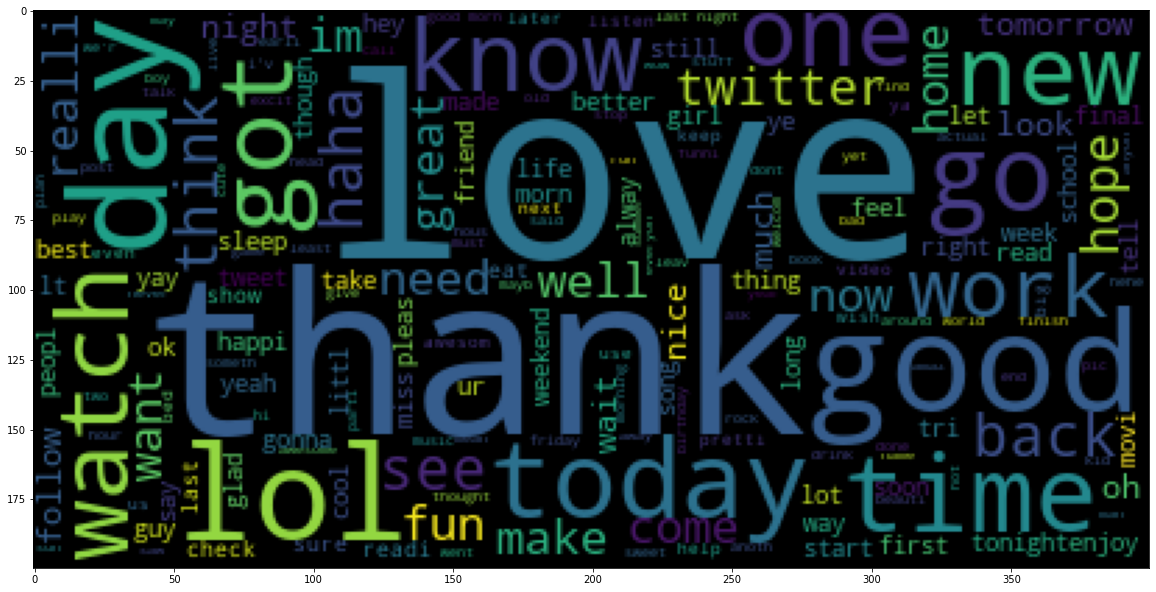

In [117]:
# Recheck word cloud
pos_text = dataset.data[dataset.data.sentiment == 'Positive'].text
neg_text = dataset.data[dataset.data.sentiment == 'Negative'].text
pos_wc = WordCloud().generate(" ".join(pos_text))
neg_wc = WordCloud().generate(" ".join(neg_text))
plt.figure(figsize=(20,20))
plt.imshow(pos_wc)

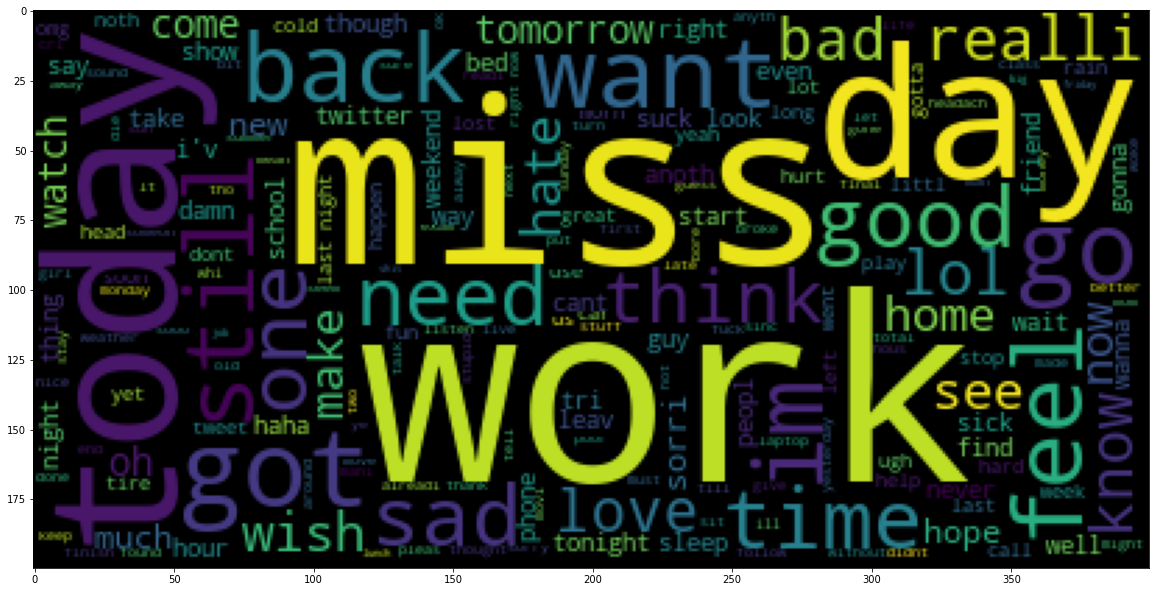

In [118]:
plt.figure(figsize=(20,20))
plt.imshow(neg_wc)

Much cleaner upon visual inspection, without as many irrelevant or unimportant words.

## Tokenization
In a general sense, tokenization is breaking the raw text into small chunks called tokens. Tokenization is a required process for NLP. When we feed in the text from a tweet, the machine needs to be able to understand what it all means and process it appropriately. In the case of a sentence, we can break it into words as tokens. For example, the previous sentence would have 15 tokens, starting at [In] and ending with [tokens]. Tokenization usually also throws away certain characters, like punctuation. Tokenization is important for many reasons. 

1.   These tokens help in understanding the context or developing the model for the NLP. In many cases, we can also mask these tokens and use our ML algortihm to predict what that token will be given the tokens surrounding it (this is how Google Autocomplete is trained I believe!).  
2.   The tokenization helps in interpreting the meaning of the text by analyzing the sequence of the words. This is more important in this situation; tokenization allows for interpretation of each Tweet inputted. It also allows a sentence to be converted into tokens that can be used as 'features', which is necessary for our future Sequential model.

In [119]:
MAX_NB_WORDS = 100000 # Define a max word length
MAX_SEQUENCE_LENGTH = 30 # Define a max sequence length (given Twitter character limits this seems reasonable)

In [120]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer() # Declare tokenizer object and convert all text to be tokens
tokenizer.fit_on_texts(dataset.make_train_df().text)

word_index = tokenizer.word_index # Allows maping of each token to an index in a dict (for Sequential model)
VOCAB_SIZE = len(tokenizer.word_index) + 1
print("Vocabulary Size :", VOCAB_SIZE)

Vocabulary Size : 14155


## Padding and Encoding

Padding is performed to ensure there is no variance in input shapes of sequences (a requirement of the model). (i.e., should all be same length.) Padding in this context refers to adding extra blank space to a sequence. We add extra space here up to the maximum sequence length. This is necessary because not all Tweets are the same length!

In [121]:
from keras.preprocessing.sequence import pad_sequences # pad_sequences pads sequences to the same length

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Save in our final train/test variables
X_train = pad_sequences(tokenizer.texts_to_sequences(dataset.make_train_df().text),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(dataset.make_test_df().text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

labels = dataset.make_train_df().sentiment.unique().tolist()

X_train: (7500, 30)
X_test: (2500, 30)


Label encoding here essentially means we want to convert the "Positive" and "Negative" labels to 0 and 1 for binary classification.

In [122]:
encoder = LabelEncoder() # Use sklearn tool: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(dataset.make_train_df().sentiment.to_list())

y_train = encoder.transform(dataset.make_train_df().sentiment.to_list())
y_test = encoder.transform(dataset.make_test_df().sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

y_train: (7500, 1)
y_test: (2500, 1)


## Embeddings

Previously when discussing tokenization, we mentioned how tokens are essentially features and a sentence is a feature vector. Embeddings are similar to the idea of the feature vector - it's a representation of words within their contexts. However, by my understanding, it's the vector representation of that word in a space that is defined by the other words with similar meaning. This way, a machine can infer context of the word by those it is surrounded by, giving the word meaning through its context. The 'space' where other words are contained have to be learned on a preset dictionary. While this can be done ourselves using other AI algorithms, it is easier to use established ones. GloVe and word2vec are both methods to learn a standalone word embedding within the context of a text corpus. These representations can be very abstract, but essentially, what word2vec and GloVe can do is to define a vector space where given a word, they can create a vector for that word that places it within that vector space. An example of this intuition which I found helpful was the following: 



> "We find that these representations are surprisingly good at capturing syntactic and semantic regularities in language, and that each relationship is characterized by a relation-specific vector offset. This allows vector-oriented reasoning based on the offsets between words. For example, the male/female relationship is automatically learned, and with the induced vector representations, “King – Man + Woman” results in a vector very close to “Queen.” " -- [Linguistic Regularities in Continuous Space Word Representations](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/rvecs.pdf), 2013.

Here, we use GloVe (given it is newer and generally thought of an improved version of word2vec in some contexts) to define embeddings.

GloVe from: https://nlp.stanford.edu/projects/glove/

Tutorial: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

Helpful article: https://machinelearningmastery.com/what-are-word-embeddings/

In [98]:
# Download GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-05-01 00:40:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-01 00:40:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-01 00:40:03--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [124]:
# Select embeddings
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300

In [125]:
# Map words to known embeddings by parsing the data of pre-trained embeddings
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [126]:
# Create embedding matrix and space which can be loaded into the "embedding layer" of our LSTM model for use in defining the context of each token
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

## LSTM Construction and Training

With all of the data preprocessed and embeddings defined, we can begin building and training the model. LSTMs (long short term memory) are a sequence model based on the recurrent neural network (RNN) architecture. Most neural networks we have learned about in the course are feedforward neural networks, ie., each layer outputs to another layer in front. RNNs and LSTMs have feedback connections, where they allow information that is sent forward to another node to also persist in the original node. A great analogy I found explaining this is the following:

> For example, imagine you want to classify what kind of event is happening at every point in a movie. It’s unclear how a traditional neural network could use its reasoning about previous events in the film to inform later ones. -- https://colah.github.io/posts/2015-08-Understanding-LSTMs/

By looping back around, RNNs and LSTMs allow information to persist. You can imagine why this is important in natural language tasks, where context is important to understand language. LSTMs are unique RNNs because they are designed to allow for context detection from points far away from one another. This can be especially useful in sentences because context for one word may not always be placed next to the word itself in the embedding or vector space.

To build an LSTM, the key architecture is as follows:

1.   Embedding Layer - This layer is used as a vector space with pre-trained embeddings, and generates an embedding vector for each input sequence.
2.   Conv1D Layer - This is used to convolve large data into smaller feature vectors for memory and processing. (I don't think this is characteristic of every LSTM, but can be included for dimension reduction)
3.   LSTM Layer - The RNN-based layer we discussed.
4.   Dense Layer - Fully connected layer used for final classification.

The optimizer used for the model was Adam. Batch Size was 256. Epochs was 10. I tried a few different parameters for the LR, including 5e-3, 1e-3, 5e-4, and 1e-5. The three former caused overfitting while the one latter led to extremely slow training and inconsistent training loss. Ultimately, a middle ground of 2e-4 was chosen.

In [127]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D, Input, Conv1D, Bidirectional
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [135]:
LR = 2e-4
BATCH_SIZE = 256
EPOCHS = 8

In [104]:
tf.test.is_gpu_available() # Ran out of GPU time on my Colab, but this should run with GPU.

False

In [136]:
# Define LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(Conv1D(64, 5, activation='relu'))
model_lstm.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model_lstm.add(Dense(512, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(512, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

from tensorflow.keras.optimizers import Adam

model_lstm.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate = LR),
    metrics=['accuracy']
)

In [137]:
history = model_lstm.fit(
    X_train, 
    y_train, 
    batch_size = BATCH_SIZE, 
    epochs = EPOCHS,
    validation_data = (X_test, y_test))

Epoch 1/8
30/30 [==============================] - 17s 353ms/step - loss: 0.6930 - accuracy: 0.5072 - val_loss: 0.6889 - val_accuracy: 0.5728
Epoch 2/8
30/30 [==============================] - 10s 333ms/step - loss: 0.6817 - accuracy: 0.5691 - val_loss: 0.6663 - val_accuracy: 0.6180
Epoch 3/8
30/30 [==============================] - 10s 331ms/step - loss: 0.6459 - accuracy: 0.6312 - val_loss: 0.6315 - val_accuracy: 0.6348
Epoch 4/8
30/30 [==============================] - 10s 332ms/step - loss: 0.6171 - accuracy: 0.6615 - val_loss: 0.6142 - val_accuracy: 0.6640
Epoch 5/8
30/30 [==============================] - 12s 391ms/step - loss: 0.5980 - accuracy: 0.6779 - val_loss: 0.6044 - val_accuracy: 0.6708
Epoch 6/8
30/30 [==============================] - 15s 493ms/step - loss: 0.5843 - accuracy: 0.6921 - val_loss: 0.5938 - val_accuracy: 0.6828
Epoch 7/8
30/30 [==============================] - 10s 347ms/step - loss: 0.5693 - accuracy: 0.7061 - val_loss: 0.5875 - val_accuracy: 0.6912
Epoch 

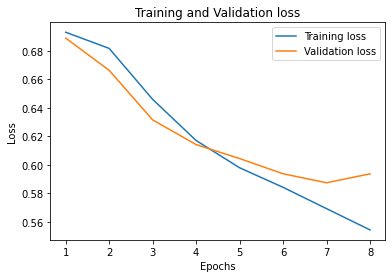

In [138]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Training loss appears to decrease across epochs, however validation loss fluctuates around 0.6-0.7. This shows that the model may be overfit to the training data and does not generalize well.

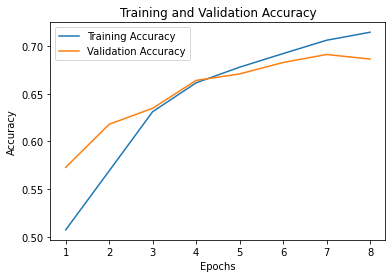

In [139]:
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The results seen in the loss are reflected in the accuracy. The model appears to stop improving in performance around epoch 2, which is also where loss no longer decreases. Looking for potential solutions to this, my first instinct is to try hyperparameter optimization. Reading https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4. Different parameters and what I tried below:

- **Dropout**: Dropout is a technique to prevent overfitting by silencing or dropping out various nodes. Doing trial and error, I found that a SpatialDropout of 0.2 and a Dropout of 0.5 seem to lead to the highest accuracy. These values are also within the standards that are normally accepted as mentioned in the article.
- **Batch Size**: should always be in powers of 2. Large sizes make large gradient steps compared to smaller ones for the same number of samples “seen”. I started with a batch size of 32 but because of the slowly decreasing loss, I thought increasing the batch size should work the best. A size of 256 led to an increasing validation loss while the training loss was decreasing (at around epoch 5), indicating potential overfitting. The 256 batch size model also led to a validation accuracy stagnating around 0.71. Considering this pattern emerged at a batch size of 32 as well, despite overfitting concerns I chose 256 because it provided the best validation accuracy.
- **Learning Rate**: This appeared to make a small difference. Having the learning rate too high led to overfitting. 5e-3, 1e-3, and 5e-4 were too high, however 1e-5 was too low. I picked 3e-4 as a middle ground. I no longer found there was overfitting, however the validation accuracy decreased to around 0.69 from a previous peak acheived at 0.72. Knowing the model is less likely to be overfit is more important to me, however, and as such I chose 3e-4 as the LR.
- **Epochs**: Following the rule (described in the article above) where you should extend the number of epochs to just before you see signs of overfitting, I found an epoch # of ~8 was enough (+/- 1 depending on the random sample), past that the validation loss would no longer decrease.

However while fixing (somewhat) the overfitting, we sacrifice a little bit of predictive accuracy. To resolve this problem, I wonder if the data is the limitation. We have access to 1,600,000 Tweets, and with more data, the model could potentially perform better. Creating a new dataset with 10x the Tweets:

In [140]:
# New dataset with 100,000 Tweets
dataset_2 = FeatureDataset("/content/training.1600000.processed.noemoticon.csv", 100000)

In [141]:
# Text preprocess
dataset_2.data.text = dataset_2.data.text.apply(lambda x: preprocess(x)) # apply to all text in dataset

In [142]:
# Tokenize
tokenizer.fit_on_texts(dataset.make_train_df().text)

word_index = tokenizer.word_index # allows maping of each token to an index in a dict
VOCAB_SIZE = len(tokenizer.word_index) + 1
print("Vocabulary Size :", VOCAB_SIZE)

Vocabulary Size : 14155


In [143]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(tokenizer.texts_to_sequences(dataset_2.make_train_df().text),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(dataset_2.make_test_df().text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

labels = dataset_2.make_train_df().sentiment.unique().tolist()

Training X Shape: (75000, 30)
Testing X Shape: (25000, 30)


In [144]:
encoder = LabelEncoder()
encoder.fit(dataset_2.make_train_df().sentiment.to_list())

y_train = encoder.transform(dataset_2.make_train_df().sentiment.to_list())
y_test = encoder.transform(dataset_2.make_test_df().sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (75000, 1)
y_test shape: (25000, 1)


In [145]:
# Define LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(Conv1D(64, 5, activation='relu'))
model_lstm.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model_lstm.add(Dense(512, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(512, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

from tensorflow.keras.optimizers import Adam

model_lstm.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate = LR),
    metrics=['accuracy']
)

In [146]:
history = model_lstm.fit(
    X_train, 
    y_train, 
    batch_size = BATCH_SIZE, 
    epochs = EPOCHS,
    validation_data = (X_test, y_test))

Epoch 1/8
293/293 [==============================] - 108s 349ms/step - loss: 0.6272 - accuracy: 0.6421 - val_loss: 0.5749 - val_accuracy: 0.6931
Epoch 2/8
293/293 [==============================] - 102s 347ms/step - loss: 0.5808 - accuracy: 0.6901 - val_loss: 0.5586 - val_accuracy: 0.7077
Epoch 3/8
293/293 [==============================] - 102s 347ms/step - loss: 0.5597 - accuracy: 0.7088 - val_loss: 0.5447 - val_accuracy: 0.7183
Epoch 4/8
293/293 [==============================] - 103s 351ms/step - loss: 0.5435 - accuracy: 0.7219 - val_loss: 0.5393 - val_accuracy: 0.7201
Epoch 5/8
293/293 [==============================] - 103s 350ms/step - loss: 0.5303 - accuracy: 0.7316 - val_loss: 0.5334 - val_accuracy: 0.7268
Epoch 6/8
293/293 [==============================] - 103s 350ms/step - loss: 0.5201 - accuracy: 0.7393 - val_loss: 0.5330 - val_accuracy: 0.7277
Epoch 7/8
293/293 [==============================] - 103s 352ms/step - loss: 0.5103 - accuracy: 0.7451 - val_loss: 0.5342 - val_ac

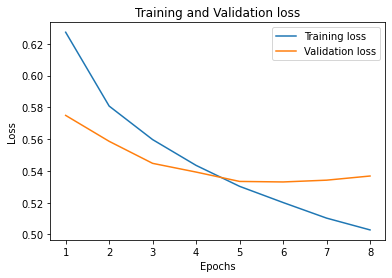

In [147]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

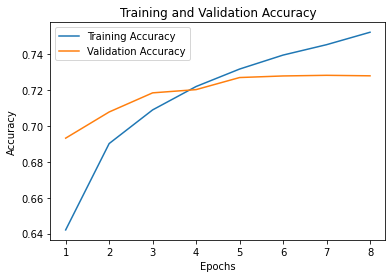

In [148]:
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Training on a dataset of 100,000 Tweets certainly appears to improve trends in training and validation. Interesting observations include:
- The validation loss performs better than the training loss until epoch 5 where it stabilizes, potentially suggesting that at this stage the model becomes less generalizeable to other Tweets.
- Similarly, 0.72 appears to be a point where validation accuracy stagnates. 
- The validation accuracy and loss improves compared to the 10,000 Tweet dataset.
- At epoch 9, the validation accuracy dips below the training accuracy and the val_loss > training loss. This suggests that at this point, overfitting may begin. As such, an epoch of 8 or 9 might be a better selection than the arbitrary epoch length of 10.
- A batch size of 512 appeared to be effective - 1024 led to a pattern indicative of overfitting around epoch 5. 

## Model Statistics

In [161]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# code for plotting confusion matrix / model statistics taken from: https://www.kaggle.com/code/arunrk7/nlp-beginner-text-classification-using-lstm
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label', fontsize=17)
    plt.xlabel('Predicted Label', fontsize=17)

In [159]:
def label_to_sentiment(score):
    if score > 0.5:
      return "Positive"
    else:
      return "Negative"

predictions = model_lstm.predict(X_test, verbose = 1, batch_size = 10000)
y_pred = [label_to_sentiment(prediction) for prediction in predictions]

3/3 [==============================] - 8s 2s/step


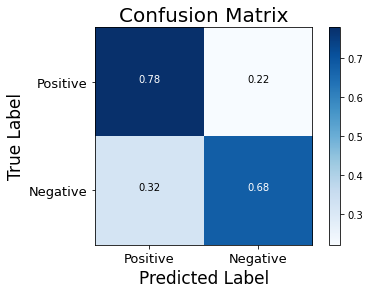

In [162]:
conf_matrix = confusion_matrix(dataset_2.make_test_df().sentiment.to_list(), y_pred)
plot_confusion_matrix(conf_matrix, classes = dataset_2.make_test_df().sentiment.unique(), title="Confusion Matrix")
plt.show()

In [172]:
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)
ppv = tp/(tp+fp)
npv = tn/(fn+tn)
accuracy = (tn+tp)/(tn+fp+tp+fn)
print("Sensitivity: " + str(round(sensitivity, 2)) + ", ", "Specificity: " + str(round(specificity, 2)) + ", ", "PPV: " + str(round(ppv, 2)) + ", ", "NPV: " + str(round(npv, 2)) + ", ", "Accuracy: " + str(round(accuracy, 2)))

Sensitivity: 0.68,  Specificity: 0.78,  PPV: 0.76,  NPV: 0.71,  Accuracy: 0.73


In [170]:
print(classification_report(list(dataset_2.make_test_df().sentiment), y_pred))

              precision    recall  f1-score   support

    Negative       0.71      0.78      0.74     12428
    Positive       0.76      0.68      0.71     12572

    accuracy                           0.73     25000
   macro avg       0.73      0.73      0.73     25000
weighted avg       0.73      0.73      0.73     25000



The model statistics are displayed above. The specificity of the model is the highest out of all statistics at 0.78, which indicates that the model is good at ruling in negative sentiments. In other words, the model has few false negatives. The sensitivity is lower at 0.68, however, which indicates the model is not as strong at identifying positive sentiments. The PPV (precision of positive sentiment) is high at 0.76, reflecting the higher sensitvity and indicating that there is 76% of all positive sentiments were classified correctly. On the other hand, NPV is at 0.71, indicating that 71% of all negative sentiments were classified correctly. The F1-score is a balance between both precision and recall, and hovers consistently around 0.70-0.75. With an overall accuracy of approximately 0.73, this reflects a moderately appropriate model. Future steps for this model are to train it on more data (which is certainly feasible given training time on the scale of hours), as well as to try different models on the data.

For instance, transformer models like BERT are new, state of the art models that can perform much better than LSTMs and RNNs. As well, as a personal goal, I would love to implement this again in PyTorch and huggingface, which seems to be faster growing in popularity over TensorFlow.